<a href="https://colab.research.google.com/github/gsbrennan/pysurfing/blob/main/NEW_data_oxford_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Packages:

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV


#### Dataset 1 (12882_2021_2474_MOESM1_ESM.csv)
Data used is from the supplementary information section found in the paper [[1]](https://bmcnephrol.biomedcentral.com/articles/10.1186/s12882-021-02474-z#Sec24).

----

[1] Ilyas, H., Ali, S., Ponum, M., Hasan, O., Mahmood, M.T., Iftikhar, M. and Malik, M.H., 2021. Chronic kidney disease diagnosis using decision tree algorithms. BMC nephrology, 22(1), pp.1-11.


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
illyas_data = pd.read_csv("/content/drive/MyDrive/MPI-2023-Materials/data_subsets/12882_2021_2474_MOESM1_ESM.csv")

#### Data reformatting: cleaning column names and adding egfr calculation/staging

In [28]:
## clean column names, values and replace ? with nan

illyas_data.rename(columns={"'race '": 'race'}, inplace=True)
illyas_data.loc[illyas_data['race']  == '\'African american\'', 'race'] = '\'African American\''
illyas_data.loc[illyas_data['sex'] == '\'m \'', 'sex'] = 'm'
illyas_data[illyas_data=='?'] = np.nan

In [29]:
## identify subgroups of features and stages

num_cols = ['age', 'bp', 'bgr', 'bu', 'sod', 'pot', 'hemo', 'pcv',  'rbcc']
nom_cols = ['al', 'su', 'sg', 'rbc', 'pc', 'pcc', 'race','sex','htn', 'dm', 'cad', 'appet', 'pe', 'ane']

all_cols = list(illyas_data.columns)
y_col = 'sc'

illyas_data[num_cols+['sc']] = illyas_data[num_cols+['sc']].astype(float)

stage_dict = {'stage1': 1, 'stage2': 2, 'stage3A': 3, 'stage3B': 4, 'stage4': 5, 'stage5': 6, '\'not ckd\'': 0}
illyas_data['class'] = [stage_dict[stag] for stag in illyas_data['class']]

In [30]:
## egfr and stage calculations

def egfr_calculator(sc, age, gender, race):
  if np.isnan(sc):
    return np.nan
  if gender == 'f':
    kappa = 0.7
    alpha = -0.329
  elif gender == 'm':
    kappa = 0.9
    alpha = -0.411
  else:
    return np.nan

  egfr = 141*(np.min([1, sc/kappa])**alpha)*(np.max([1, sc/kappa])**-1.209)*(0.993**age)

  if gender == 'f':
    egfr = egfr * 1.018
  if race == '\'African American\'':
    egfr = egfr * 1.159
  return egfr


  # def egfr_calculator_other(sc, age, gender, race):
#   if np.isnan(sc):
#     return np.nan
#   # if gender == 'f':
#   #   kappa = 0.7
#   #   alpha = -0.329
#   # elif gender == 'm':
#   #   kappa = 0.9
#   #   alpha = -0.411
#   # else:
#   #   return np.nan

#   egfr = 175 * sc**-1.154 * age**-0.203

#   if gender == 'f':
#     egfr = egfr * 0.742
#   if race == '\'African American\'':
#     egfr = egfr * 1.210
#   return egfr

def egfr_to_stage_calculator(egfr):
  if np.isnan(egfr):
    return np.nan
  elif egfr >= 100:
    return 0
  elif egfr >= 90:
    return 1
  elif egfr >= 60:
    return 2
  elif egfr >= 45:
    return 3
  elif egfr >= 30:
    return 4
  elif egfr >= 15:
    return 5
  else:
    return 6

In [31]:
illyas_data['egfr']= [egfr_calculator(row[11], row[0], row[16], row[8]) for idx, row in illyas_data.iterrows()]
# illyas_data['egfr_other']= [egfr_calculator_other(row[11], row[0], row[16], row[8]) for idx, row in illyas_data.iterrows()]

illyas_data['egfr_to_stage']= [egfr_to_stage_calculator(row[25]) for idx, row in illyas_data.iterrows()]
# illyas_data['egfr_to_stage_other']= [egfr_to_stage_calculator(row[27]) for idx, row in illyas_data.iterrows()]

In [32]:
## unit test egfr_calculator

print(illyas_data.loc[234, 'egfr'])
print(141*1.018*((1.3/0.7)**-1.209)*(0.993**37))

52.3666874186499
52.3666874186499


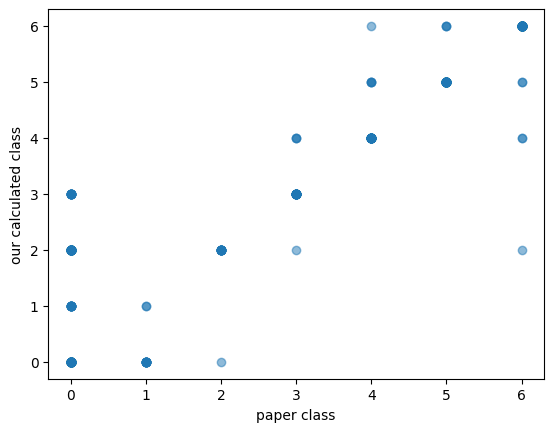

0.6736292428198434


In [33]:
plt.scatter(illyas_data['class'], illyas_data['egfr_to_stage'], alpha=0.5)
plt.xlabel('paper class')
plt.ylabel('our calculated class')
plt.show()


print((illyas_data['class']==illyas_data['egfr_to_stage']).sum()/(400-17))

In [34]:
illyas_data = illyas_data.rename(columns={'class': 'ilyasclass', 'egfr_to_stage': 'ourclass'})
# illyas_data = illyas_data.drop('egfr', axis=1)

#### Data cleaning fuctions:


In [35]:
def one_hot_cat(df, cols):
	for col in cols:
		# Get one hot encoding of column
		one_hot_vals = pd.get_dummies(df[col])
		# Prepend column name to values so we know which attribute the column is associated with
		for one_hot_val in one_hot_vals:
			one_hot_vals.rename({one_hot_val:'{}_{}'.format(col, one_hot_val)}, axis=1, inplace=True)
		# Drop column as it is now encoded
		df = df.drop(col, axis = 1)
		# Join the encoded df
		df = df.join(one_hot_vals)
	return df

def impute_num(df, cols, standardize = True, strategy = 'mean', k = 5):
	# Initialize imputer based on strategy
	if strategy == 'knn':
		fill_NaN = KNNImputer(missing_values=np.nan, n_neighbors=k)
	else:
		fill_NaN = SimpleImputer(missing_values=np.nan, strategy=strategy)

	imputed = fill_NaN.fit_transform(df[cols]) # Impute

	print('Creatinine mean:', np.mean(df['sc']), '\nCreatinine std:', np.std(df['sc']))
	# Standardize data
	if standardize:
		scaler = StandardScaler()
		imputed = scaler.fit_transform(imputed)

	imputed_df = pd.DataFrame(imputed) # Convert back to df
	imputed_df.columns = df[cols].columns # Re-add column names to df
	imputed_df.index = df[cols].index # Re-add index to df
	df[cols] = imputed_df # Replace original columns with imputed columns

	return df

def get_col_types():
	num_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'rbcc'] # 'wbcc',
	cat_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'race', 'sex']
	class_cols = ['ilyasclass', 'ourclass']
	return num_cols, cat_cols, class_cols

def clean_data(standardize = True, strategy = 'mean', k = 5, log_creat = False, drop_creat = True):
	data = illyas_data #pd.read_csv("./data/chronic_kidney_disease.csv")
 # Convert sg, al, and su to strings since they are actually categorical
	data = data.astype({'sg': 'str', 'al': 'str', 'su': 'str'})

	num_cols, cat_cols, class_cols = get_col_types()

	if drop_creat:
		data = data[~np.isnan(data['sc'])]

	if log_creat:
		data['sc'] = np.log(data['sc'])

	one_hot_data = one_hot_cat(data, cat_cols) # + class_cols) # One hot encode the categorical and class columns
	return impute_num(one_hot_data, num_cols, standardize, strategy, k) # Impute and standardize numeric data
	# impute_num(one_hot_data, num_cols, standardize, strategy, k) # Impute and standardize numeric data
	# print(data.head())
	# return data


#### Plotting function:

In [36]:
## plotting results function

def model_analysis(y_test, y_pred, dep_var_name = 'stage', title='Test set'):
  print('mse', mean_squared_error(y_test, y_pred))
  print('r2', r2_score(y_test, y_pred))

  line_min = np.max([np.min(y_test), np.min(y_pred)])
  line_max = np.min([np.max(y_test), np.max(y_pred)])
  plt.scatter(y_test, y_pred)
  plt.plot([line_min,line_max], [line_min,line_max], '--r')
  plt.xlabel('True log({})'.format(dep_var_name))
  plt.ylabel('Predicted log({})'.format(dep_var_name))
  # plt.xlabel('True {}'.format(dep_var_name))
  # plt.ylabel('Predicted {}'.format(dep_var_name))
  plt.title(title)
  plt.show()


#### Regression defns:

In [37]:
## Linear regression

def linear_reg(X, y, dep_var_name = 'stage', test_size=0.25):
  # X and y clean and ready

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=4)
  model = LinearRegression()
  model.fit(X_train, y_train)
  print(model.intercept_, model.coef_)
  y_pred = model.predict(X_test)
  model_analysis(y_test, y_pred, dep_var_name)

  # outliers = [each[1] for each in list(zip(y_train,X_train.tolist())) if each[0] == -1]
  # print(len(outliers))
  # for i in outliers:
  #   print(i)

  y_train_pred = model.predict(X_train)
  model_analysis(y_train, y_train_pred, dep_var_name, title='Train set')

  return y_test, y_pred, model

In [38]:
## Random forest regression

def rforest_reg(X,y, test_size=0.25):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  # set_config(print_changed_only=False)

  rfr = RandomForestRegressor(n_estimators = 200, min_samples_split = 5,
                              min_samples_leaf = 4, max_features = 'sqrt',
                              max_depth = None, bootstrap = True)
  print(rfr)
  rfr.fit(X_train, y_train)

  score = rfr.score(X_test, y_test)
  print("R-squared:", score)
  ypred = rfr.predict(X_test)

  mse = mean_squared_error(y_test, ypred)
  print("MSE: ", mse)
  print("RMSE: ", mse*(1/2.0))

  model_analysis(y_test, ypred, 'Creatinine')
  y_train_pred = rfr.predict(X_train)
  model_analysis(y_train, y_train_pred, 'Creatinine', title = 'Train set')



In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 120, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 65, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


#### Options for data cleaning:

In [40]:
	num_cols = ['age', 'bp', 'bgr', 'bu', 'sod', 'pot', 'hemo', 'pcv', 'rbcc'] # 'wbcc','sc',
	cat_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'race', 'sex']
	class_cols = ['ilyasclass', 'ourclass', 'egfr']

In [41]:
# before cleaning
illyas_data.head(5)

,age,bp,sg,al,su,rbc,pc,pcc,race,bgr,...,rbcc,htn,dm,cad,appet,pe,ane,ilyasclass,egfr,ourclass
0,48.0,80.0,1.02,1,0,NaN,normal,notpresent,'not African American',121.0,...,5.2,yes,yes,no,good,no,no,2,71.077494,2.0
1,7.0,50.0,1.02,4,0,NaN,normal,notpresent,'not African American',NaN,...,4.2,no,no,no,good,no,no,1,140.892391,0.0
2,62.0,80.0,1.01,2,3,normal,normal,notpresent,'not African American',423.0,...,5.3,no,yes,no,poor,no,yes,4,29.642810,5.0
3,48.0,70.0,1.005,4,0,normal,abnormal,present,'not African American',117.0,...,3.9,yes,no,no,poor,yes,yes,5,17.640215,5.0
4,51.0,80.0,1.01,2,0,normal,normal,notpresent,'not African American',106.0,...,4.6,no,no,no,good,no,no,4,43.394361,4.0


In [42]:
data = clean_data(standardize = True, strategy = 'mean', k = 5, log_creat = True, drop_creat = True) # drop_creat removes rows corresponding to 'sc' creatinine values NaN

Creatinine mean: 0.5486850981652804 
Creatinine std: 0.9246006162539556


In [43]:
# after cleaning
data.head()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,rbcc,...,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes,race_'African American',race_'not African American',sex_f,sex_m
0,-0.230569,0.257046,-0.354519,-0.428536,-0.396240,0.000000,0.00000,1.054013,0.625329,0.619037,...,1,0,1,0,1,0,0,1,0,1
1,-2.685811,-1.938639,0.000000,-0.786689,-0.834770,0.000000,0.00000,-0.439199,-0.100567,-0.512710,...,1,0,1,0,1,0,0,1,0,1
2,0.607806,0.257046,3.675914,-0.090282,0.042290,0.000000,0.00000,-1.058336,-0.947446,0.732212,...,0,1,1,0,0,1,0,1,1,0
3,-0.230569,-0.474849,-0.407903,-0.030590,0.850439,-2.825796,-0.74108,-0.475619,-0.826463,-0.852234,...,0,1,0,1,0,1,0,1,0,1
4,-0.050917,0.257046,-0.554706,-0.627510,-0.229518,0.000000,0.00000,-0.329940,-0.463515,-0.060011,...,1,0,1,0,1,0,0,1,1,0


#### Run random Forest regression:


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
R-squared: 0.7612634298009774
MSE:  0.1706106175324531
RMSE:  0.08530530876622655
mse 0.1706106175324531
r2 0.7612634298009774


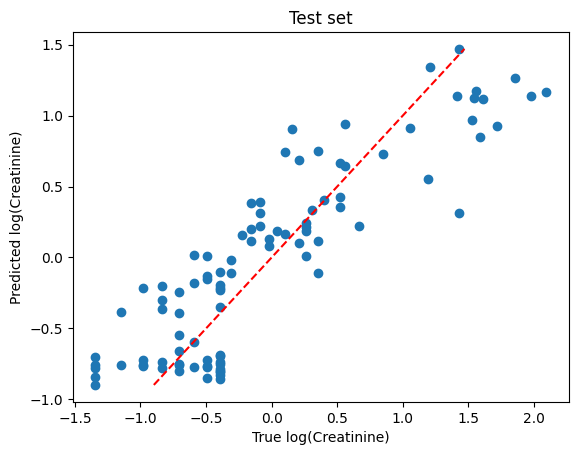

mse 0.2356706629747154
r2 0.7847126393467807


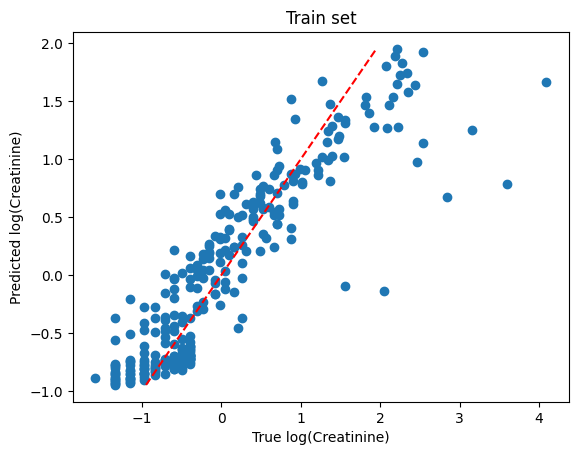

In [44]:
## Random Forest regression
# all features
# dep var: creatinine

## remove rows with missing sc values if not already done in clean_data function by uncommenting partial line below
data_sc_cut = data #.loc[data['sc'].notna()]
y_sc = data_sc_cut['sc']

data_sc_cut = data_sc_cut.drop('sc',axis = 1)
X_all_sc = data_sc_cut.drop(class_cols, axis=1)

## run random forest
# y_test_all_sc, y_pred_all_sc, model_sc =
rforest_reg(X_all_sc, y_sc.astype(float))


#### Run linear regression:

3.167132683967705 [ 0.6275207   0.06153064  0.19058843  0.65035762 -0.05586263 -0.13122866
 -0.6133301  -0.18589668 -0.17045402]
mse 1.7604471654069798
r2 0.612230375803281


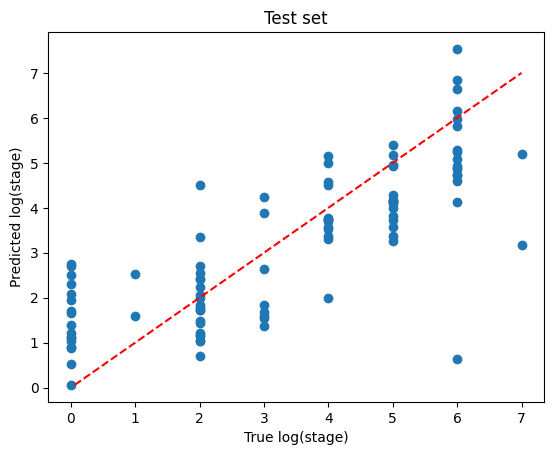

mse 1.863456496465681
r2 0.6214079803530566


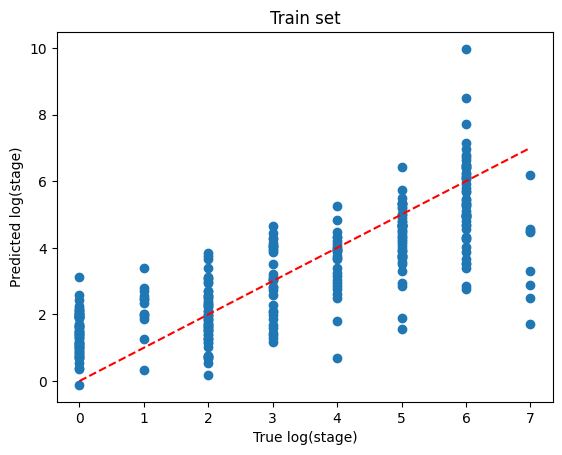

In [45]:
## Linear regression
# numerical features only
# dep var: stage

X_num = data[num_cols]
# y = data['ilyasclass']
y = data['ourclass']
# print(X_num)

## encode stage categories to 0-6
enc = LabelEncoder()
y_enc = enc.fit_transform(y)

## run linear regression
y_test_num, y_pred_num, _ = linear_reg(X_num, y_enc, dep_var_name = 'stage')


7.207338875257529 [ 4.84543876e-01  3.39054622e-03 -5.87564568e-04  7.64144054e-01
  3.90874481e-02 -1.34229452e-01 -9.91328918e-02 -1.67589172e-01
  3.12536435e-02  5.53476008e-01  2.01123360e-01  1.99665119e-01
 -2.87756296e-01 -2.67504057e-01 -3.99004134e-01 -9.03363564e-01
 -3.65473531e-01  5.19772781e-01  2.87640213e-01  5.33818329e-01
 -2.36456177e+00  2.29216754e+00  3.30803779e-01 -1.91501700e-01
  9.74858420e-01  4.37114682e-01  3.74241509e-01 -8.67180841e-01
 -1.05833585e+00  3.07937124e-01 -4.89880096e-01 -2.05821299e-01
 -5.75205461e-03  1.23323904e+00  1.23499591e+00 -4.42785149e-01
  2.01243292e-01 -1.95325682e-01 -4.62161748e-02 -8.50574801e-03
 -2.33036109e-01 -3.16840364e-02  2.27247792e-01  3.21234388e-01
 -1.25670632e-01  2.17412228e-01 -2.18484718e-02 -6.48848059e-02
  6.48848059e-02 -4.98058704e+00 -5.30866852e+00]
mse 1.9949233053709865
r2 0.5605828589316679


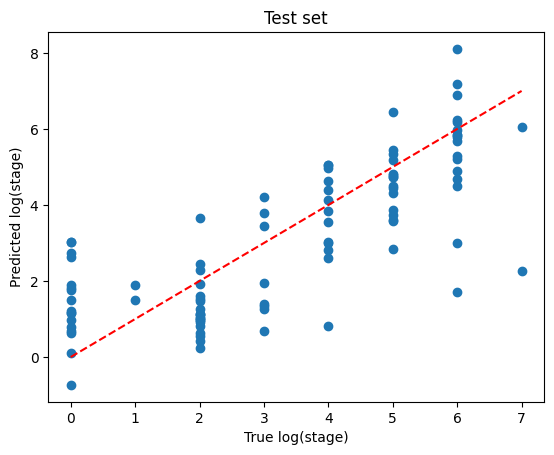

mse 1.1600384847100214
r2 0.7643189880592766


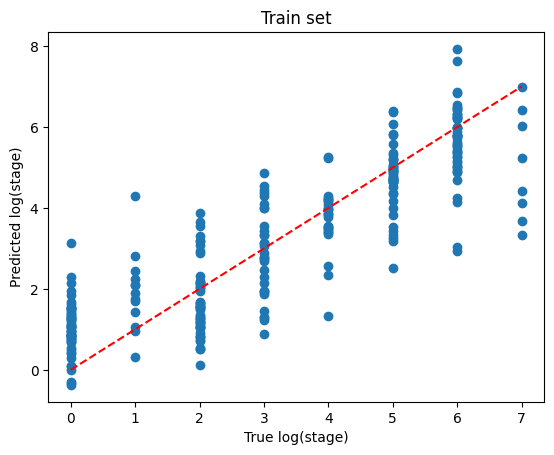

In [46]:
## Linear regression
# all features
# dep var: stage

X_all = data.drop(class_cols, axis=1)
# print(X_all.columns)
X_all = X_all.drop('sc',axis = 1)
y = data['ourclass']

## encode stage categories to 0-6
enc = LabelEncoder()
y_enc = enc.fit_transform(y)

## run linear regression
y_test_all, y_pred_all, _ = linear_reg(X_all, y_enc, dep_var_name = 'stage')




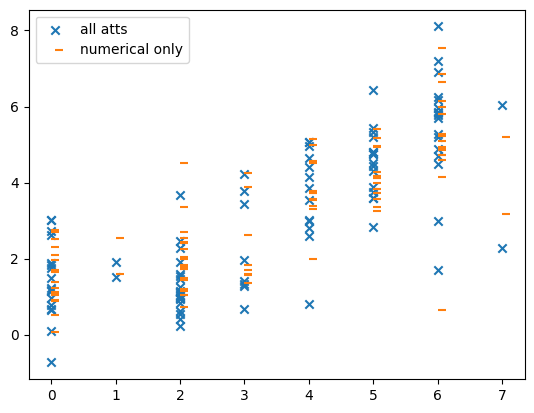

In [47]:
## comparing numerical feature results vs all feature results using Linear regression

plt.scatter(y_test_all, y_pred_all, marker='x', label='all atts')
plt.scatter(y_test_all, y_pred_num, marker=1, label='numerical only')
plt.legend()
plt.show()

-0.15633196523884207 [ 0.03469529  0.02788348 -0.04332268  0.53825975 -0.13197325  0.00473108
 -0.04709047 -0.0451344  -0.01256609  0.4963675   0.07562675  0.11956165
 -0.07796481 -0.07195851 -0.54163259 -0.1330318  -0.01880907  0.11514725
  0.15924497  0.09385105 -1.21210607  0.99570368 -0.11768356 -0.23832649
  0.44193668  0.15905342  0.34329948 -0.37614969 -0.21212984  0.04081915
 -0.01308753 -0.14577406 -0.09307755  0.19491247  0.12167477 -0.19913385
  0.09235449 -0.04520157 -0.06157779 -0.03141253 -0.07536683  0.09443002
  0.23625166  0.24435803  0.08632365  0.15352745  0.17715423  0.13156822
 -0.13156822 -0.11393131 -0.07690054]
mse 0.3065180909083893
r2 0.642581840867519


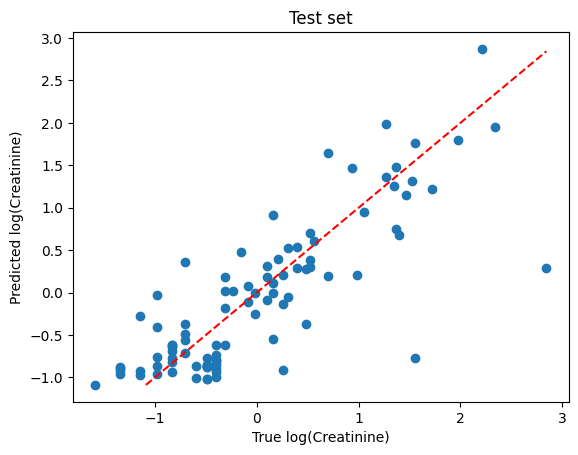

mse 0.21351905804719049
r2 0.796188667977989


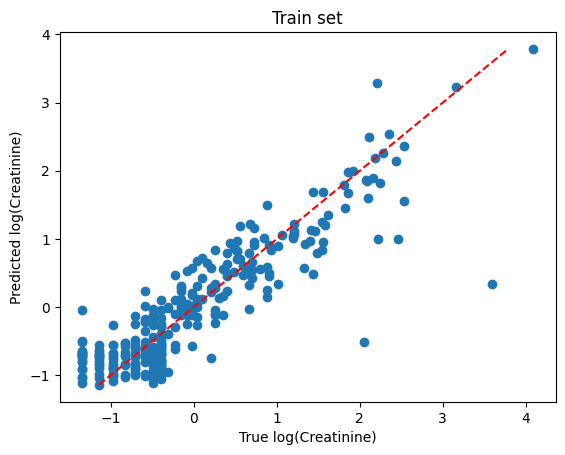

In [48]:
## Linear regression
# all features
# dep var: creatinine


## remove rows with missing sc values if not already done in clean_data function by uncommenting partial line below
data_sc_cut = data #.loc[data['sc'].notna()]
y_sc = data_sc_cut['sc']

data_sc_cut = data_sc_cut.drop('sc',axis = 1)
X_all_sc = data_sc_cut.drop(class_cols, axis=1)



## run linear regression
y_test_all_sc, y_pred_all_sc, _ = linear_reg(X_all_sc, y_sc.astype(float), dep_var_name = 'Creatinine')
